## Spam mail classification based on UCI spammail database
### Overall Outline

1. **Data Explore and Data Clean**

2. **Feature Engineering**

3. **Model Selection and Model buliding**
    - logistic
    - SVM
    - Descion Tree (Using the grid search to find the best params)
    - Random Forest (Using the grid search to find the best params)

4. **Evaluation**

**Import necessary libraries**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import svm
import numpy as np
from sklearn import metrics
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import KFold
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegressionCV,LinearRegression,LogisticRegression
from sklearn.svm import SVC
import warnings
warnings.filterwarnings('ignore')

**Data Explore and Data Clean**

In [2]:
def read_word_label(file = 'spambase/spambase.names'):
    feature_labels = []
    with open(file, 'r') as f:
        data = f.readlines()
        for line in data:
            if(line.startswith("word") or line.startswith("char") or line.startswith("capital")):
                feature_labels.append(line.split(":")[0])
    feature_labels.append("label")
    return feature_labels

In [3]:
spamdata = pd.read_csv("spambase/spambase.data", names = read_word_label()) # Read data
spamdata.head()

,word_freq_make,word_freq_address,word_freq_all,word_freq_3d,word_freq_our,word_freq_over,word_freq_remove,word_freq_internet,word_freq_order,word_freq_mail,...,char_freq_;,char_freq_(,char_freq_[,char_freq_!,char_freq_$,char_freq_#,capital_run_length_average,capital_run_length_longest,capital_run_length_total,label
0,0.00,0.64,0.64,0.0,0.32,0.00,0.00,0.00,0.00,0.00,...,0.00,0.000,0.0,0.778,0.000,0.000,3.756,61,278,1
1,0.21,0.28,0.50,0.0,0.14,0.28,0.21,0.07,0.00,0.94,...,0.00,0.132,0.0,0.372,0.180,0.048,5.114,101,1028,1
2,0.06,0.00,0.71,0.0,1.23,0.19,0.19,0.12,0.64,0.25,...,0.01,0.143,0.0,0.276,0.184,0.010,9.821,485,2259,1
3,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.137,0.0,0.137,0.000,0.000,3.537,40,191,1
4,0.00,0.00,0.00,0.0,0.63,0.00,0.31,0.63,0.31,0.63,...,0.00,0.135,0.0,0.135,0.000,0.000,3.537,40,191,1


In [4]:
### Observe the overall description about the data
spamdata.info() # There is no missing data in this data set. 
# If it has, we need to find a method to fill the NA values.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4601 entries, 0 to 4600
Data columns (total 58 columns):
word_freq_make                4601 non-null float64
word_freq_address             4601 non-null float64
word_freq_all                 4601 non-null float64
word_freq_3d                  4601 non-null float64
word_freq_our                 4601 non-null float64
word_freq_over                4601 non-null float64
word_freq_remove              4601 non-null float64
word_freq_internet            4601 non-null float64
word_freq_order               4601 non-null float64
word_freq_mail                4601 non-null float64
word_freq_receive             4601 non-null float64
word_freq_will                4601 non-null float64
word_freq_people              4601 non-null float64
word_freq_report              4601 non-null float64
word_freq_addresses           4601 non-null float64
word_freq_free                4601 non-null float64
word_freq_business            4601 non-null float64
word_freq

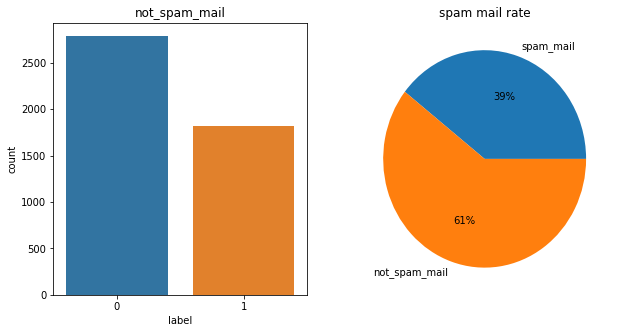

In [5]:
### Observe the balance of the dataset, 
###if the data is very unbalanced, we need to perform oversampling or undersampling techniques
spam_mail = spamdata['label'].value_counts()[1]
not_spam_mail = spamdata['label'].value_counts()[0]
plt.figure(figsize = (10,5))
plt.subplot(121)
sns.countplot(x='label', data=spamdata)
plt.title('not_spam_mail')
plt.subplot(122)
plt.pie([spam_mail, not_spam_mail],labels=['spam_mail','not_spam_mail'],autopct='%1.0f%%')
plt.title('spam mail rate') 
plt.show()
### This data set is OK, do not need to balance the data

**Feature Engineering**

In [6]:
spamdata.corr()['label'].sort_values(ascending=False).head()

label               1.000000
word_freq_your      0.383234
word_freq_000       0.334787
word_freq_remove    0.332117
char_freq_$         0.323629
Name: label, dtype: float64

From the corresponding matrix, we can see that all the data correlation coefficients are not too small.
Therefore, using all of them to build a classifer

In [7]:
### Using grid search method to find the best parameters for each machine learning method.
def grid_search_model(clf, params):
    grid = GridSearchCV(clf,params, cv = 10,scoring= "roc_auc")
    res = grid.fit(X_TRAIN,y_TRAIN)
    return res

In [8]:
## Using the grid search to find the best parameters
et_params = {
    'n_jobs': [-1],
    'n_estimators': [i*10 for i in range(1,10)],
    'max_features': ["sqrt"],
    'max_depth': [i for i in range(1,10)],
    'min_samples_leaf': [2],
    "class_weight":["balanced"]
    
}

rf_params = {
    'n_jobs': [-1],
    'n_estimators': [i*10 for i in range(1,10)],
    'max_features': [i/10 for i in range(1,10)],
    'max_depth': [3],
    'min_samples_leaf': [2],
    "class_weight":["balanced"]
}

svm_params = {
    "class_weight":"balanced",
    "gamma": "scale",
    "probability":True,
    "kernel" :"rbf",
    "probability":True
}

**Perform some grid search**

In [9]:
## grid search
# et_res = grid_search_model(ExtraTreesClassifier(),et_params)
# rf_res = grid_search_model(RandomForestClassifier(),rf_params)

# save grid search results
import pickle
# pickle.dump(et_res,open("./et_res.pkl","wb"))
# pickle.dump(rf_res,open("./rf_res.pkl","wb"))

# reload grid search results
et_res = pickle.load(open("./et_res.pkl","rb"))
rf_res = pickle.load(open("./rf_res.pkl","rb"))

In [10]:
def get_average(error_list):
    sum = 0
    for i in error_list:
        sum += i
    return sum/len(error_list)

**Build K fold performance method for each algorithm**

In [11]:
def k_fold_performance(clf,K):
    ERRS = []
    ### Split the data to training set and testing set.
    train_np = spamdata.values
    y = train_np[:, 57]
    X = train_np[:, 0:57]
    ### Using K-flod method to split dataset to 10 fold (9 for training and 1 for testing)
    kf = KFold(n_splits=K, random_state=42, shuffle=True)
    i = 0
    for train, test in kf.split(spamdata.values):
        i += 1
        print("k-fold：%d iteration" % (i))
        X_train,X_test=X[train],X[test]
        Y_train,Y_test=y[train],y[test]
        ### Data normalization
        X_train = preprocessing.minmax_scale(X_train)
        X_test = preprocessing.minmax_scale(X_test)
        clf = clf.fit(X_train, Y_train)
        y_pred = clf.predict(X_test)
        tn, fp, fn, tp = confusion_matrix(Y_test, y_pred).ravel()
        print ("False Positive: ",fp)
        print ("False Negative: ",fn)
        ERR = (fp+fn)/len(Y_test)
        print ("Error Rate: ",ERR)
        ERRS.append(ERR)
        print ("---------------------------")
    print ("Average Error Rate", get_average(ERRS))
    print ("---------------------------")

**Building models and print out the evaluations**

In [12]:
print ("Decision Tree")
clf = ExtraTreesClassifier(**et_res.best_params_)
k_fold_performance(clf,3)

Decision Tree
k-fold：1 iteration
False Positive:  95
False Negative:  60
Error Rate:  0.10104302477183832
---------------------------
k-fold：2 iteration
False Positive:  73
False Negative:  74
Error Rate:  0.09582790091264667
---------------------------
k-fold：3 iteration
False Positive:  22
False Negative:  108
Error Rate:  0.08480104370515329
---------------------------
Average Error Rate 0.09389065646321276
---------------------------


In [13]:
print ("Random Forest")
clf = RandomForestClassifier(**rf_res.best_params_)
k_fold_performance(clf,3)

Random Forest
k-fold：1 iteration
False Positive:  85
False Negative:  58
Error Rate:  0.09322033898305085
---------------------------
k-fold：2 iteration
False Positive:  130
False Negative:  44
Error Rate:  0.11342894393741851
---------------------------
k-fold：3 iteration
False Positive:  17
False Negative:  131
Error Rate:  0.09654272667971298
---------------------------
Average Error Rate 0.10106400320006077
---------------------------


In [14]:
print ("svm")
clf = SVC()
k_fold_performance(clf,3)

svm
k-fold：1 iteration
False Positive:  51
False Negative:  227
Error Rate:  0.18122555410691005
---------------------------
k-fold：2 iteration
False Positive:  41
False Negative:  206
Error Rate:  0.16101694915254236
---------------------------
k-fold：3 iteration
False Positive:  28
False Negative:  296
Error Rate:  0.21135029354207435
---------------------------
Average Error Rate 0.18453093226717557
---------------------------


In [15]:
print ("Logistic Regression")
clf = LogisticRegression()
k_fold_performance(clf,3)

Logistic Regression
k-fold：1 iteration
False Positive:  69
False Negative:  79
Error Rate:  0.09647979139504563
---------------------------
k-fold：2 iteration
False Positive:  70
False Negative:  66
Error Rate:  0.08865710560625815
---------------------------
k-fold：3 iteration
False Positive:  47
False Negative:  153
Error Rate:  0.1304631441617743
---------------------------
Average Error Rate 0.10520001372102601
---------------------------
